In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
transform = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(0.5), 
        transforms.RandomGrayscale(0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [3]:
batch_size = 100

train_data = datasets.CIFAR10('data3', train=True, download=True, transform=transform["train"])
test_data = datasets.CIFAR10('data3', train=False, download=True, transform=transform["test"])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.norm4 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))

        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = self.norm4(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

In [7]:
model = CNN()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data)
        loss = loss_function(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target, top_class)
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev)
                dev_loss = loss_function(dev_pred, target_dev)
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev, dev_top_class)
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/100..  Training Loss: 1.452..  Validation Loss: 1.147..  Training Accuracy: 0.483..  Validation Accuracy: 0.587
Epoch: 5/100..  Training Loss: 0.903..  Validation Loss: 0.832..  Training Accuracy: 0.682..  Validation Accuracy: 0.712
Epoch: 10/100..  Training Loss: 0.779..  Validation Loss: 0.760..  Training Accuracy: 0.726..  Validation Accuracy: 0.734
Epoch: 15/100..  Training Loss: 0.720..  Validation Loss: 0.713..  Training Accuracy: 0.748..  Validation Accuracy: 0.752
Epoch: 20/100..  Training Loss: 0.674..  Validation Loss: 0.701..  Training Accuracy: 0.764..  Validation Accuracy: 0.753
Epoch: 25/100..  Training Loss: 0.654..  Validation Loss: 0.688..  Training Accuracy: 0.772..  Validation Accuracy: 0.762
Epoch: 30/100..  Training Loss: 0.627..  Validation Loss: 0.667..  Training Accuracy: 0.780..  Validation Accuracy: 0.772
Epoch: 35/100..  Training Loss: 0.605..  Validation Loss: 0.669..  Training Accuracy: 0.786..  Validation Accuracy: 0.769
Epoch: 40/100..  Training 

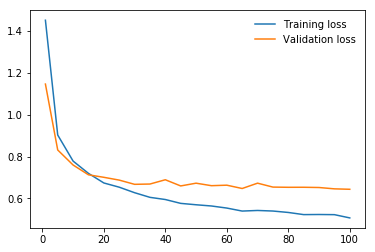

In [9]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

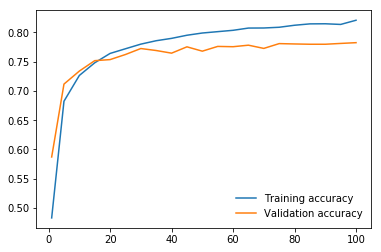

In [10]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [11]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test, top_class_test)
print(acc_test/iter_3)

0.7865000000000001
